In [2]:
from IPython.display import display, clear_output
import plotly.graph_objs as go
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import time
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

from sklearn.decomposition import PCA

# Testing GPU acceleration

To set the GPU acceleration properly up on Pytorch for a .ipynb file on Axon. <br>
You have to first use nvidia-smi to see an unused GPU,  <br>
then use nvidia-smi -L to see its MIG ID, and set it as an environmental variable.<br>


In [3]:
# Prompt for the CUDA_VISIBLE_DEVICES value
cuda_device = input("Enter the CUDA_VISIBLE_DEVICES value: ")
os.environ['CUDA_VISIBLE_DEVICES'] = cuda_device

In [4]:
# Check if CUDA is available
is_cuda_available = torch.cuda.is_available()
print("Is CUDA available:", is_cuda_available)

# Determine the device to use: GPU (CUDA), Apple Silicon (MPS), or CPU
DEVICE = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print("Using device:", DEVICE)

Is CUDA available: True
Using device: cuda


In [5]:
if torch.cuda.is_available():
    # Test tensor operation on GPU
    test_tensor = torch.tensor([1.0, 2.0, 3.0], device="cuda")
    print("Test tensor on CUDA:", test_tensor)

Test tensor on CUDA: tensor([1., 2., 3.], device='cuda:0')


In [6]:
if is_cuda_available:
    try:
        test_tensor = torch.tensor([1, 2, 3], device=DEVICE)
        print("Successfully moved a tensor to the device:", test_tensor)
    except RuntimeError as e:
        print("Error moving a tensor to the device:", e)

Successfully moved a tensor to the device: tensor([1, 2, 3], device='cuda:0')


# Defining VAE classes

In [7]:
class StandardVAE(nn.Module):
    def __init__(self, latent_dim=20, w_dim=10):
        super(StandardVAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder layers
        # Input: [bs, 1, 28, 28]
        self.enc_conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)  # Output: [bs, 16, 14, 14]
        self.enc_conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1) # Output: [bs, 32, 7, 7]
        self.enc_fc1 = nn.Linear(32 * 7 * 7, w_dim)  # Output: [bs, 128]
        # Two output layers for the latent space
        self.enc_fc2 = nn.Linear(w_dim, latent_dim)  # For mu, Output: [bs, latent_dim]
        self.enc_fc3 = nn.Linear(w_dim, latent_dim)  # For logvar, Output: [bs, latent_dim]

        # Decoder layers
        self.dec_fc1 = nn.Linear(latent_dim, w_dim)  # Output: [bs, 128]
        self.dec_fc2 = nn.Linear(w_dim, 32 * 7 * 7)  # Output: [bs, 1568]
        self.dec_conv1 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1)  # Output: [bs, 16, 14, 14]
        self.dec_conv2 = nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1)  # Output: [bs, 1, 28, 28]

    def encode(self, x):
        h = F.relu(self.enc_conv1(x))
        h = F.relu(self.enc_conv2(h))
        h = torch.flatten(h, start_dim=1)
        h = F.relu(self.enc_fc1(h))
        return self.enc_fc2(h), self.enc_fc3(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        # Returns a tensor with the same size as input that is filled with random numbers from a normal distribution with mean 0 and variance 1.
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.dec_fc1(z)) 
        h = F.relu(self.dec_fc2(h)).view(-1, 32, 7, 7) # .view reshapes [bs, 1568] to [bs, 32, 7, 7]
        h = F.relu(self.dec_conv1(h))
        return torch.sigmoid(self.dec_conv2(h))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), z, mu, logvar

def loss_function_standard(recon_x, z, mu, logvar, x):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # Can reweight BCE + KLD as desired
    return BCE + KLD

LakeVAE inheirits from StandardVAE, but with a modified forward pass.
Its encoding and decoding layers are identicle. 
The only difference is that the forward pass stores and returns all the intermediate values required to calculate the modified reconstruction loss.

Since pixel values are either 0 or 1, we can use BCE between the input image and output image.
However, for the intermediate layers, that are continuous, we use can MSE instead. This is also what the paper's code does in practice.

In [8]:
class LakeVAE(StandardVAE):
    def forward(self, x):
        # Encoder layers
        # Input: [bs, 1, 28, 28]
        enc_conv1_out = F.relu(self.enc_conv1(x))  # Output: [bs, 16, 14, 14]
        enc_conv2_out = F.relu(self.enc_conv2(enc_conv1_out))  # Output: [bs, 32, 7, 7]
        flattened = torch.flatten(enc_conv2_out, start_dim=1)  # Output: [bs, 1568]
        
        # w = F.relu(self.enc_fc1(flattened))  # Output: [bs, 128] # Eqn (5) in LAKE paper
        w = self.enc_fc1(flattened)  # Not sure if relu is used in the paper or not. Output: [bs, 128] # Eqn (5) in LAKE paper
        
        mu, logvar = self.enc_fc2(w), self.enc_fc3(w)  # Output: [bs, latent_dim], [bs, latent_dim] # Eqn (6) in LAKE paper

        # Reparameterization and Decoding layers
        z = self.reparameterize(mu, logvar)  # Output: [bs, latent_dim] # Eqn (7) in LAKE paper
        dec_fc1_out = F.relu(self.dec_fc1(z))  # Output: [bs, 128]
        dec_fc2_out = F.relu(self.dec_fc2(dec_fc1_out)).view(-1, 32, 7, 7)  # Output: [bs, 1568], then reshaped to [bs, 32, 7, 7]
        dec_conv1_out = F.relu(self.dec_conv1(dec_fc2_out))  # Output: [bs, 16, 14, 14]
        recon_x = torch.sigmoid(self.dec_conv2(dec_conv1_out))  # Output: [bs, 1, 28, 28]

        return recon_x, z, mu, logvar, enc_conv1_out, enc_conv2_out, w, dec_fc1_out, dec_fc2_out, dec_conv1_out

def loss_function_lake(recon_x, z, mu, logvar, enc_conv1_out, enc_conv2_out, w, dec_fc1_out, dec_fc2_out, dec_conv1_out, x):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    # Layer-wise reconstruction loss
    layer_loss = F.mse_loss(enc_conv1_out, dec_conv1_out) + F.mse_loss(enc_conv2_out, dec_fc2_out) + F.mse_loss(w, dec_fc1_out)
    # KL Divergence
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD + layer_loss

# Definining Utility Classes for training and visualisation

In [9]:
def save_model(model, path):
    torch.save(model.state_dict(), path)

In [10]:
def load_model(model, path, device):
    model.load_state_dict(torch.load(path, map_location=device))

In [11]:
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

In [12]:
def generate_and_save_images(model, epoch, latent_vectors, folder="generated_images"):
    model.eval()
    with torch.no_grad():
        generated = model.decode(latent_vectors).cpu()
    for i, img in enumerate(generated):
        plt.imshow(img.squeeze(), cmap='gray')
        plt.savefig(f"{folder}/img_{epoch}_{i}.png")
    model.train()

In [13]:
def plot_latent_space(model, data_loader, device, num_samples=1000):
    model.eval()
    latents = []
    labels = []
    with torch.no_grad():
        for data, label in data_loader:
            data = data.to(device)
            mu, _ = model.encode(data)
            latents.append(mu.cpu().numpy())
            labels.append(label.numpy())
            if len(latents) * data_loader.batch_size > num_samples:
                break
    
    latents = np.concatenate(latents, axis=0)[:num_samples]
    labels = np.concatenate(labels, axis=0)[:num_samples]
    
    pca = PCA(n_components=2)
    latents_reduced = pca.fit_transform(latents)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(latents_reduced[:, 0], latents_reduced[:, 1], c=labels, cmap='viridis', s=2, alpha=0.6)
    plt.colorbar()
    plt.title("Latent Space (PCA-reduced)")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.show()
    model.train()

In [14]:
is_processing = False
def plot_losses_interactive(model, model_name, model_states, train_losses, val_losses, train_loader, val_loader, device, best_train_loss, best_val_loss):
    global is_processing
    epochs = len(train_losses)
    fig = go.FigureWidget()

    # Add traces for training and validation losses
    fig.add_trace(go.Scatter(x=list(range(1, epochs + 1)), y=train_losses, mode='lines+markers', name='Training Loss'))
    fig.add_trace(go.Scatter(x=list(range(1, epochs + 1)), y=val_losses, mode='lines+markers', name='Validation Loss'))

    # Set layout for the plot
    fig.update_layout(
        title=f'Interactive {model_name} Training and Validation Loss',
        xaxis_title='Epoch',
        yaxis_title='Loss',
        width=800, height=600
    )

    # Function to update the image on clicking a point on the plot
    def update_image(trace, points, selector):
        global is_processing
        if is_processing:
            return
        is_processing = True
    
        if points.point_inds:
            epoch = points.point_inds[0]
            model.load_state_dict(model_states[epoch])
            model.eval()
    
            # Determine which dataloader and best loss to use based on which trace was clicked
            if trace.name == 'Training Loss':
                data_loader = train_loader
                current_loss = train_losses[epoch]
                best_loss = best_train_loss
                loss_type = 'Training'
            elif trace.name == 'Validation Loss':
                data_loader = val_loader
                current_loss = val_losses[epoch]
                best_loss = best_val_loss
                loss_type = 'Validation'

            # Calculate loss as a percentage of the best loss
            loss_percentage = (best_loss / current_loss) * 100

            # Generate and display an image
            data, _ = next(iter(data_loader))
            data = data.to(device)
            reconstructed_img = model(data)[0].cpu().squeeze()

            if reconstructed_img.ndim == 3:  # If image has 3 dimensions, take the first one
                reconstructed_img = reconstructed_img[0]

            # Display information and the image
            plt.figure(figsize=(5, 5))
            plt.imshow(reconstructed_img.detach().numpy(), cmap='gray')
            plt.title(f'{model_name} {loss_type} Loss\nEpoch: {epoch + 1}\nLoss: {current_loss:.4f} ({loss_percentage:.2f}% rel to best)')
            plt.axis('off')
            clear_output(wait=True)
            display(plt.gcf())
            model.train()
    
        is_processing = False

    # Attach the click handler to the plot
    fig.data[0].on_click(update_image)  # For training loss
    fig.data[1].on_click(update_image)  # For validation loss

    # Display the plot
    display(fig)

In [15]:
def validate_vae(model, val_loader, loss_function, device):
    total_loss = 0
    with torch.no_grad():
        for data, _ in val_loader:
            data = data.to(device)
            outputs = model(data)
            loss = loss_function(*outputs, data)
            total_loss += loss.item()
    return total_loss / len(val_loader.dataset)

modify train_vae to instead to the probability density estimation training.
I'm not sure how its training, or what this is doing, considering there's no updates to anything?
write the functions for rec_euclidean and rec_cosine.
The first thing the VAE classes return with their forward pass is their reconstructed images x'.

In [16]:
def train_vae(model, train_loader, val_loader, loss_function, optimiser, epochs, device, model_name, plot_interval=1):
    train_losses = []
    val_losses = []
    model_states = []
    best_val_loss = float('inf')
    best_model_state = None
    best_epoch = 0

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            optimiser.zero_grad()
            outputs = model(data)
            loss = loss_function(*outputs, data)
            loss.backward()
            optimiser.step()
            total_loss += loss.item()

        train_loss = total_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        model.eval()
        val_loss = validate_vae(model, val_loader, loss_function, device)
        val_losses.append(val_loss)

        # Save the current model state
        model_states.append(model.state_dict().copy())

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            best_epoch = epoch

        print(f'Epoch {epoch+1}, Training Loss: {train_loss}, Validation Loss: {val_loss}')

        print(f'Saving {model_name} model at epoch {epoch+1}')
        save_model(model, f'{model_name}_{epoch+1}.pth')
        

    if best_model_state is not None:
        model_path = f"best_{model_name}_epoch_{best_epoch}.pth"
        save_model(model, model_path)
        print(f"Best {model_name} model saved as {model_path}")
        model.load_state_dict(best_model_state)

    best_train_loss = min(train_losses)
    best_val_loss = min(val_losses)
    plot_losses_interactive(model, model_name, model_states, train_losses, val_losses, train_loader, val_loader, device, best_train_loss, best_val_loss)
        
    return train_losses, val_losses

# Loading Dataset and Training

This cell loads in the mnist dataset into train, validation, and test dataloaders.
While doing so, they are normalised to be [0,1] and turned into tensors.

In [17]:
transform = transforms.Compose([transforms.ToTensor()])

# Download the MNIST dataset
mnist_trainset = datasets.MNIST(root='~/.pytorch/MNIST_data/', train=True, download=True, transform=transform)

# Splitting the dataset into train and validation sets
train_size = int(0.8 * len(mnist_trainset))
validation_size = len(mnist_trainset) - train_size
train_dataset, validation_dataset = random_split(mnist_trainset, [train_size, validation_size])

# Download and load the test data
test_dataset = datasets.MNIST(root='~/.pytorch/MNIST_data/', train=False, download=True, transform=transform)

In [18]:
# Training parameters
batch_size = 64
learning_rate = 1e-3
epochs = 100

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
validationloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=False)

Standard_VAE = StandardVAE().to(DEVICE)
Lake_VAE = LakeVAE().to(DEVICE)

In [232]:
# Run cell to train Standard VAE
print(f'Training parameters: batch_size={batch_size}, learning_rate={learning_rate}, epochs={epochs}')
print("Training Standard_VAE...")
Optimiser_Standard = torch.optim.Adam(Standard_VAE.parameters(), lr=learning_rate)
Trained_Standard_VAE = train_vae(Standard_VAE, trainloader, validationloader, loss_function_standard, Optimiser_Standard, epochs, DEVICE, "Standard_VAE")

Training parameters: batch_size=64, learning_rate=0.001, epochs=100
Training Standard_VAE...
Epoch 1, Training Loss: 216.63298744710286, Validation Loss: 186.9185244954427
Saving Standard_VAE model at epoch 1
Epoch 2, Training Loss: 174.41765334065755, Validation Loss: 163.65676192220053
Saving Standard_VAE model at epoch 2
Epoch 3, Training Loss: 159.54346567789713, Validation Loss: 156.08525419108074
Saving Standard_VAE model at epoch 3
Epoch 4, Training Loss: 154.21702128092448, Validation Loss: 152.24092138671875
Saving Standard_VAE model at epoch 4
Epoch 5, Training Loss: 151.63424127197266, Validation Loss: 150.68963724772135
Saving Standard_VAE model at epoch 5
Epoch 6, Training Loss: 150.0141619466146, Validation Loss: 148.87698071289063
Saving Standard_VAE model at epoch 6
Epoch 7, Training Loss: 148.69508521525066, Validation Loss: 148.07883365885417
Saving Standard_VAE model at epoch 7
Epoch 8, Training Loss: 147.77145233154297, Validation Loss: 147.31320817057292
Saving Sta

FigureWidget({
    'data': [{'mode': 'lines+markers',
              'name': 'Training Loss',
              'type': 'scatter',
              'uid': '17792019-aada-497a-81a2-337584bef66c',
              'x': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
                    19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
                    35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
                    51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
                    67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82,
                    83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98,
                    99, 100],
              'y': [216.63298744710286, 174.41765334065755, 159.54346567789713,
                    154.21702128092448, 151.63424127197266, 150.0141619466146,
                    148.69508521525066, 147.77145233154297, 146.95817606608074,
                    146.36571536254883, 1

In [233]:
# Run cell to train Lake VAE
print(f'Training parameters: batch_size={batch_size}, learning_rate={learning_rate}, epochs={epochs}')
print("Training Lake_VAE...")
Optimiser_Lake = torch.optim.Adam(Lake_VAE.parameters(), lr=learning_rate)
Trained_Lake_VAE = train_vae(Lake_VAE, trainloader, validationloader, loss_function_lake, Optimiser_Lake, epochs, DEVICE, "Lake_VAE")

Training parameters: batch_size=64, learning_rate=0.001, epochs=100
Training Lake_VAE...
Epoch 1, Training Loss: 196.0902937825521, Validation Loss: 154.23970231119793
Saving Lake_VAE model at epoch 1
Epoch 2, Training Loss: 146.30639093017578, Validation Loss: 139.89667443847657
Saving Lake_VAE model at epoch 2
Epoch 3, Training Loss: 136.34115384928384, Validation Loss: 132.61003776041667
Saving Lake_VAE model at epoch 3
Epoch 4, Training Loss: 130.5356474609375, Validation Loss: 128.2311095377604
Saving Lake_VAE model at epoch 4
Epoch 5, Training Loss: 127.09249858601888, Validation Loss: 125.73383709716796
Saving Lake_VAE model at epoch 5
Epoch 6, Training Loss: 125.20727039591472, Validation Loss: 124.09460024007161
Saving Lake_VAE model at epoch 6
Epoch 7, Training Loss: 123.87977361043295, Validation Loss: 123.33071480305989
Saving Lake_VAE model at epoch 7
Epoch 8, Training Loss: 122.89019830322266, Validation Loss: 122.39476843261718
Saving Lake_VAE model at epoch 8
Epoch 9, T

FigureWidget({
    'data': [{'mode': 'lines+markers',
              'name': 'Training Loss',
              'type': 'scatter',
              'uid': 'e4a5419b-30b1-4557-b6df-28d6caf173cb',
              'x': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
                    19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
                    35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
                    51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
                    67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82,
                    83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98,
                    99, 100],
              'y': [196.0902937825521, 146.30639093017578, 136.34115384928384,
                    130.5356474609375, 127.09249858601888, 125.20727039591472,
                    123.87977361043295, 122.89019830322266, 122.05293002319335,
                    121.40767249552408, 12

Training only uses 25MiB of GPU memory. Perhaps could try Jupyterlab and jupyterlab-nvdashboard to monitor GPU usage.

# Loading Models

In [19]:
# best_standard_vae_path = 'best_Standard_VAE_epoch_X.pth'
# best_lake_vae_path = 'best_Lake_VAE_epoch_Y.pth'

standard_vae_path = 'Standard_VAE_100.pth'
lake_vae_path = 'Lake_VAE_100.pth'

# Load the best models
Standard_VAE = StandardVAE().to(DEVICE)
load_model(Standard_VAE, standard_vae_path, DEVICE)

Lake_VAE = LakeVAE().to(DEVICE)
load_model(Lake_VAE, lake_vae_path, DEVICE)

# Visualising Trained Latent Space

In [20]:
is_processing = False

def reconstruct_from_latent_space(model, latent_point, pca, device):
    original_latent = pca.inverse_transform([latent_point])
    original_latent_tensor = torch.from_numpy(original_latent).float().to(device)
    reconstructed_img = model.decode(original_latent_tensor).cpu()
    return reconstructed_img[0].squeeze()

def plot_latent_space_interactive(model, data_loader, device, vaename, dataname, num_samples=1000):
    model.eval()
    latents = []
    labels = []
    with torch.no_grad():
        for data, label in data_loader:
            data = data.to(device)
            mu, _ = model.encode(data)
            latents.append(mu.cpu().numpy())
            labels.append(label.numpy())
            if len(latents) * data_loader.batch_size > num_samples:
                break

    latents = np.concatenate(latents, axis=0)[:num_samples]
    labels = np.concatenate(labels, axis=0)[:num_samples]
    
    pca = PCA(n_components=2)
    latents_reduced = pca.fit_transform(latents)

    # Define a custom color scale (10 different colors for digits 0-9)
    custom_color_scale = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A',
                          '#19D3F3', '#FF6692', '#B6E880', '#FF97FF', '#FECB52']

    # Create traces for each digit with hover text
    traces = []
    for digit in range(10):
        digit_indices = np.where(labels == digit)[0]
        trace = go.Scatter(
            x=latents_reduced[digit_indices, 0], y=latents_reduced[digit_indices, 1],
            mode='markers', marker=dict(color=custom_color_scale[digit], size=10),
            name=str(digit),
            hoverinfo='text',
            text=[f'Label: {digit}, Pos: ({x:.2f}, {y:.2f})' for x, y in latents_reduced[digit_indices]]
        )
        traces.append(trace)

    # Plotly figure with separate traces
    fig = go.FigureWidget(traces)
    fig.update_layout(
        title=f'{vaename} Latent Space Visualisation of MNIST {dataname} Data',
        xaxis_title='Principal Component 1',
        yaxis_title='Principal Component 2',
        width=800, height=600,
        legend_title_text='Digit Label'
    )

    def update_image(trace, points, selector):
        global is_processing
        if is_processing:
            return
    
        is_processing = True
    
        if points.point_inds:
            idx = points.point_inds[0]
            latent_point = latents_reduced[idx]
            img = reconstruct_from_latent_space(model, latent_point, pca, device)
            plt.imshow(img.detach().numpy(), cmap='gray')
            plt.axis('off')
            clear_output(wait=True)
            display(plt.gcf())
    
        is_processing = False

    for trace in fig.data:
        trace.on_click(update_image)

    display(fig)
    model.train()

In [23]:
#plot_latent_space_interactive(Standard_VAE, trainloader, DEVICE, 'Standard VAE Epochs' ,'Training', num_samples=500)
plot_latent_space_interactive(Standard_VAE, validationloader, DEVICE, 'Standard VAE Epochs' ,'Validation', num_samples=5000)

FigureWidget({
    'data': [{'hoverinfo': 'text',
              'marker': {'color': '#636EFA', 'size': 10},
              'mode': 'markers',
              'name': '0',
              'text': [Label: 0, Pos: (1.82, 1.63), Label: 0, Pos: (1.18, 0.33),
                       Label: 0, Pos: (1.95, 0.46), ..., Label: 0, Pos: (0.87,
                       0.74), Label: 0, Pos: (1.77, 0.79), Label: 0, Pos: (1.73,
                       1.23)],
              'type': 'scatter',
              'uid': '8f3218e9-6974-4a1d-8508-c5b31a00d15a',
              'x': array([1.8172448, 1.1837072, 1.948814 , ..., 0.8692725, 1.7679049, 1.7311076],
                         dtype=float32),
              'y': array([1.6332574 , 0.33297515, 0.46378666, ..., 0.7351385 , 0.7881625 ,
                          1.2339143 ], dtype=float32)},
             {'hoverinfo': 'text',
              'marker': {'color': '#EF553B', 'size': 10},
              'mode': 'markers',
              'name': '1',
              'text': [Labe

In [25]:
#plot_latent_space_interactive(Lake_VAE, trainloader, DEVICE, 'layer-constrained VAE Epochs', 'Training', num_samples=500)
plot_latent_space_interactive(Lake_VAE, validationloader, DEVICE, 'layer-constrained VAE Epochs', 'Validiation', num_samples=5000)

FigureWidget({
    'data': [{'hoverinfo': 'text',
              'marker': {'color': '#636EFA', 'size': 10},
              'mode': 'markers',
              'name': '0',
              'text': [Label: 0, Pos: (0.75, 1.43), Label: 0, Pos: (1.41, 0.85),
                       Label: 0, Pos: (0.65, 2.25), ..., Label: 0, Pos: (0.77,
                       1.70), Label: 0, Pos: (0.68, 1.31), Label: 0, Pos: (0.78,
                       2.26)],
              'type': 'scatter',
              'uid': '828907ff-30d6-44cf-a2e2-a7ea0b6830d8',
              'x': array([0.7487708 , 1.41007   , 0.65171856, ..., 0.76621723, 0.6832378 ,
                          0.77587986], dtype=float32),
              'y': array([1.427808  , 0.84818727, 2.2479963 , ..., 1.6952932 , 1.3135802 ,
                          2.2552798 ], dtype=float32)},
             {'hoverinfo': 'text',
              'marker': {'color': '#EF553B', 'size': 10},
              'mode': 'markers',
              'name': '1',
              'text'

# Probability Density Estimation Training and Testing

Using 900 MNIST validation images (labelled 0) and 100 GAN generated MNIST images (labelled 1) to create a combined testing dataset. 
Then attempting to see if the LAKE anomaly detection can find the synthetic images.

In [31]:
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

# Load the validation dataset
mnist_validation_data = validation_dataset 

# Extract MNIST images and labels
mnist_images = mnist_validation_data.dataset.data[mnist_validation_data.indices][:900]
mnist_labels = torch.zeros(900)  # Label '0' for real MNIST data

# Load GAN generated images
gan_images_path = 'gan_generated_mnist_images.pt'
gan_images = torch.load(gan_images_path)

# Normalize the MNIST and GAN images if they are not already
mnist_images = mnist_images.float() / 255.0
mnist_images = mnist_images[:,None]
gan_images = gan_images.float() / 255.0 if gan_images.max() > 1.0 else gan_images

# Add a pure white image as an anomaly
white_image = torch.ones(1, 1, 28, 28)
white_label = torch.tensor([1])  # Anomaly label

# Combine MNIST, GAN, and white image into one dataset
combined_images = torch.cat((mnist_images, gan_images, white_image), dim=0)
combined_labels = torch.cat((mnist_labels, torch.ones(100), white_label), dim=0)

# Create a TensorDataset and DataLoader
combined_dataset = TensorDataset(combined_images, combined_labels)
combined_loader = DataLoader(combined_dataset, batch_size=64, shuffle=True)

# Check the normalization
max_pixel_value = combined_images.max()
min_pixel_value = combined_images.min()
print(f"Range of pixel values: {min_pixel_value} to {max_pixel_value}")

Range of pixel values: 0.0 to 1.0


In [32]:
# Function to encode dataset and compute reconstruction errors
def encode_and_reconstruct(model, dataloader, device):
    model.eval()
    ws = []
    rec_errors = []
    with torch.no_grad():
        for x, _ in dataloader:
            x = x.to(device)
            # Get w and x' in forward pass
            recon_x, _, _, _, _, _, w, _, _, _ = model(x)

            # Store w
            ws.append(w.cpu()) 

            # Calc and store rec_eu and rec_co
            rec_euclidean = torch.norm(x - recon_x, p=2, dim=(1, 2, 3))
            rec_cosine = F.cosine_similarity(x.view(x.size(0), -1), recon_x.view(recon_x.size(0), -1), dim=1)
            r = torch.stack((rec_euclidean, rec_cosine), dim=1)
            rec_errors.append(r.cpu()) 
            
    return torch.cat(ws, dim=0), torch.cat(rec_errors, dim=0)
    
Lake_VAE.to(DEVICE)

# For Training Data
encoded_ws, reconstruction_rs = encode_and_reconstruct(Lake_VAE, trainloader, DEVICE)
assert not torch.isnan(encoded_ws).any(), "NaNs in encoded_ws"
assert not torch.isnan(reconstruction_rs).any(), "NaNs in reconstruction_rs"
C_Train = np.hstack((encoded_ws, reconstruction_rs))
print(C_Train.shape)

# Testing Data
encoded_ws, reconstruction_rs = encode_and_reconstruct(Lake_VAE, combined_loader, DEVICE)
assert not torch.isnan(encoded_ws).any(), "NaNs in encoded_ws"
assert not torch.isnan(reconstruction_rs).any(), "NaNs in reconstruction_rs"
C = np.hstack((encoded_ws, reconstruction_rs))
print(C.shape)

(48000, 12)
(1001, 12)


There are three main things that affect the anomaly detection results. <br>
A. The model used (how well the data is compressed). The ability of your VAE to compress and reconstruct data is critical. It is contained within w and r. <br>
B. The KDE's bandwidth setting, corresponding to the smoothness of the density estimate. <br>
If it's too narrow, you might have a very bumpy estimate that's sensitive to noise. <br>
If it's too wide, the estimate might be too smooth and anomalies could be missed because they blend in with the normal data. <br>
C. Anomaly detection threshold. What proportion of your dataset you set expected to be an anomaly. <br>

In [ ]:
# KernelDensity from sklearn represents fh(s) = (1/n) ∑[i=1 to n] Kh(s - ci)
from joblib import dump

def perform_kde(C_Train):
    # Doing k-fold validation on to find good bandwidth value
    params = {'bandwidth': np.linspace(0.01, 0.2, 20)}
    grid = GridSearchCV(KernelDensity(kernel='gaussian'), params, cv=5)
    grid.fit(C_Train)
    print(f"Optimal bandwidth: {grid.best_estimator_.bandwidth}")
    kde = KernelDensity(kernel='gaussian', bandwidth=grid.best_estimator_.bandwidth)
    
    #kde = KernelDensity(kernel='gaussian', bandwidth=0.05) # Manual bandwidth setting
    kde.fit(C_Train)
    return kde

# Function to estimate density from C values
def estimate_density(kde, C):
    log_density = kde.score_samples(C)
    return np.exp(log_density)

# Calibrate and Save KDE
kde_model = perform_kde(C_Train)
dump(kde_model, 'kde_model.joblib')

density_estimates = estimate_density(kde_model, C)

# Determine anomaly threshold and detect anomalies
threshold = np.percentile(density_estimates, 10)
anomalies = density_estimates < threshold

# Calculate and print anomaly detection results
detected_anomalies = np.sum(anomalies[-101:]) 
print(f"Detected {detected_anomalies} anomalies out of 101 synthetic images.")

# Plotting
plt.figure(figsize=(12, 6))
plt.hist(density_estimates, bins=100, alpha=0.5, color='blue', label='Density Scores')
plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
plt.legend()
plt.title('Density Estimates and Anomaly Threshold')
plt.xlabel('Density Score')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

Detected 10 anomalies out of 101 synthetic images.


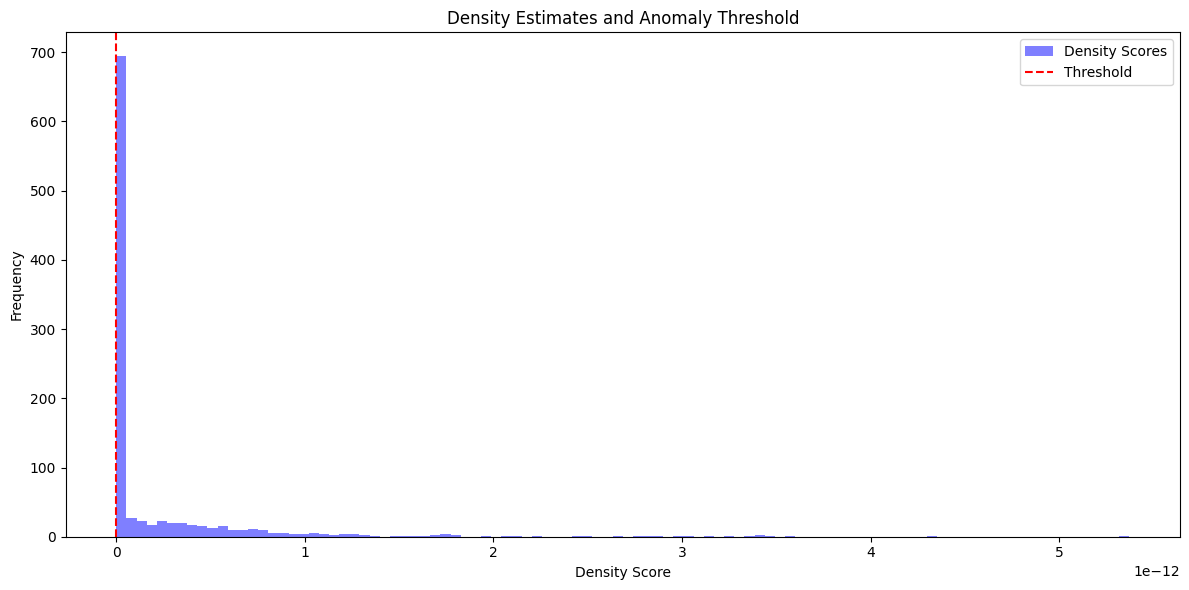

In [34]:
# Calibrate and Save KDE
from joblib import load
kde_model = load('kde_model.joblib')

# Function to estimate density from C values
def estimate_density(kde, C):
    log_density = kde.score_samples(C)
    return np.exp(log_density)

density_estimates = estimate_density(kde_model, C)

# Determine anomaly threshold and detect anomalies
threshold = np.percentile(density_estimates, 10)
anomalies = density_estimates < threshold

# Calculate and print anomaly detection results
detected_anomalies = np.sum(anomalies[-101:]) 
print(f"Detected {detected_anomalies} anomalies out of 101 synthetic images.")

# Plotting
plt.figure(figsize=(12, 6))
plt.hist(density_estimates, bins=100, alpha=0.5, color='blue', label='Density Scores')
plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
plt.legend()
plt.title('Density Estimates and Anomaly Threshold')
plt.xlabel('Density Score')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()